In [1]:
import os
import csv

dataset_dir = "data/UCF101"
output_csv = "data/test_annotations.csv"

if not os.path.exists(dataset_dir):
    raise FileNotFoundError(f"Dataset directory not found: {dataset_dir}")

rows = []

for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    for video_file in os.listdir(class_path):
        if video_file.endswith(".avi"):
            video_path = os.path.join(class_name, video_file)
            rows.append([video_path, class_name])

# Write to CSV
with open(output_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["path", "label"])
    writer.writerows(rows)

print(f" Generated test annotations: {output_csv} with {len(rows)} entries.")


 Generated test annotations: data/test_annotations.csv with 13320 entries.


In [ ]:
import os
import torch
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from torch.utils.data import DataLoader
from config import Config
from data_loader import VideoDataset
from model import CNN_LSTM
from transforms import get_transforms

# Load model from checkpoint
def load_model(checkpoint_path, device):
    model = CNN_LSTM(
        num_classes=Config.num_classes,
        sequence_length=Config.frames_per_clip,
        hidden_dim=Config.hidden_dim,
        lstm_layers=Config.lstm_layers,
        dropout=Config.dropout
    )
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model

# Load the label map from the classInd.txt file
def load_label_map(path):
    label_map = {}
    with open(path, "r") as f:
        for line in f:
            index, label = line.strip().split()
            label_map[int(index) - 1] = label  # Convert to 0-based indexing
    return label_map

def test():
    # Load the model and label map
    model = load_model(Config.model_save_path, Config.device)
    label_map = load_label_map(Config.label_map_path)

    # Initialize dataset and dataloader for testing
    transform = get_transforms(Config.img_size)
    test_dataset = VideoDataset(
        dataset_path=Config.dataset_path,
        label_map_path=Config.label_map_path,
        cache_path=Config.cache_path,
        sequence_length=Config.frames_per_clip,
        img_size=Config.img_size,
        transform=transform
    )
    test_dataset.test_annotation_path = Config.test_annotation_path  # Set the test annotation path

    test_loader = DataLoader(
        test_dataset,
        batch_size=Config.batch_size,
        shuffle=False,
        num_workers=Config.num_workers
    )

    # Prepare for evaluation
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(Config.device)
            labels = labels.to(Config.device)

            # Perform inference
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            # Collect predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    unique_classes = sorted(set(y_true) | set(y_pred))
    target_names = [label_map[i] for i in unique_classes]

    # Classification report
    report = classification_report(
        y_true,
        y_pred,
        target_names=target_names,
        labels=unique_classes,
        output_dict=True
    )
    os.makedirs(Config.results_dir, exist_ok=True)
    report_path = os.path.join(Config.results_dir, "classification_report.json")
    with open(report_path, "w") as f:
        json.dump(report, f, indent=4)
    print("Classification report saved at:", report_path)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=unique_classes)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()

    cm_path = os.path.join(Config.results_dir, "confusion_matrix.png")
    plt.savefig(cm_path)
    plt.close()
    print("Confusion matrix saved at:", cm_path)

# Run the test
test()


Testing: 100%|██████████| 1665/1665 [27:47<00:00,  1.00s/it]


Classification report saved at: results/classification_report.json
Confusion matrix saved at: results/confusion_matrix.png


In [13]:
import torch
import cv2
from PIL import Image
from config import Config
from model import CNN_LSTM
from transforms import get_transforms

def load_model():
    model = CNN_LSTM(
        num_classes=Config.num_classes,
        sequence_length=Config.frames_per_clip,
        hidden_dim=Config.hidden_dim,
        lstm_layers=Config.lstm_layers,
        dropout=Config.dropout
    ).to(Config.device)

    checkpoint = torch.load(Config.model_save_path, map_location=Config.device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

def preprocess_video(video_path, transform):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = Image.fromarray(frame)
        frames.append(frame)
    cap.release()

    total_frames = len(frames)
    if total_frames < Config.frames_per_clip:
        frames += [frames[-1]] * (Config.frames_per_clip - total_frames)
    else:
        step = total_frames // Config.frames_per_clip
        frames = frames[::step][:Config.frames_per_clip]

    frames = [transform(frame) for frame in frames]
    frames = torch.stack(frames, dim=0)  # (sequence_length, 3, img_size, img_size)
    return frames

def predict_multiple_videos(video_paths):
    model = load_model()
    transform = get_transforms(Config.img_size)

    batch = []
    for video_path in video_paths:
        frames = preprocess_video(video_path, transform)
        batch.append(frames)

    batch = torch.stack(batch, dim=0)  # (batch_size, sequence_length, 3, img_size, img_size)
    batch = batch.to(Config.device)

    with torch.no_grad():
        outputs = model(batch)
        preds = outputs.argmax(dim=1)

    predicted_classes = [Config.class_names[pred.item()] for pred in preds]

    for path, pred_class in zip(video_paths, predicted_classes):
        print(f"{path} ➔ Predicted Class: {pred_class}")

    return predicted_classes


In [14]:
video_list = [
    "data/UCF101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi",
    "data/UCF101/Archery/v_Archery_g01_c01.avi",
    "data/UCF101/PlayingPiano/v_PlayingPiano_g01_c01.avi"
]

predict_multiple_videos(video_list)


data/UCF101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi ➔ Predicted Class: ApplyEyeMakeup
data/UCF101/Archery/v_Archery_g01_c01.avi ➔ Predicted Class: Archery
data/UCF101/PlayingPiano/v_PlayingPiano_g01_c01.avi ➔ Predicted Class: PlayingPiano


['ApplyEyeMakeup', 'Archery', 'PlayingPiano']

In [16]:
video_list = [
    "data/UCF101/Surfing/v_Surfing_g01_c01.avi",
    "data/UCF101/WritingOnBoard/v_WritingOnBoard_g01_c01.avi",
    "data/UCF101/YoYo/v_YoYo_g25_c04.avi"
]

predict_multiple_videos(video_list)


data/UCF101/Surfing/v_Surfing_g01_c01.avi ➔ Predicted Class: Surfing
data/UCF101/WritingOnBoard/v_WritingOnBoard_g01_c01.avi ➔ Predicted Class: WritingOnBoard
data/UCF101/YoYo/v_YoYo_g25_c04.avi ➔ Predicted Class: YoYo


['Surfing', 'WritingOnBoard', 'YoYo']

New model fine_tuning , checkpoint_path

In [1]:
import os
import torch
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from torch.utils.data import DataLoader
from config import Config
from data_loader import VideoDataset
from model import CNN_LSTM
from transforms import get_transforms

# Load model from checkpoint
def load_model(checkpoint_path, device):
    model = CNN_LSTM(
        num_classes=Config.num_classes,
        sequence_length=Config.frames_per_clip,
        hidden_dim=Config.hidden_dim,
        lstm_layers=Config.lstm_layers,
        dropout=Config.dropout
    )
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model

# Load the label map from the classInd.txt file
def load_label_map(path):
    label_map = {}
    with open(path, "r") as f:
        for line in f:
            index, label = line.strip().split()
            label_map[int(index) - 1] = label  # Convert to 0-based indexing
    return label_map

def test():
    # Load the model and label map
    model = load_model(Config.model_save_path, Config.device)
    label_map = load_label_map(Config.label_map_path)

    # Initialize dataset and dataloader for testing
    transform = get_transforms(Config.img_size)
    test_dataset = VideoDataset(
        dataset_path=Config.dataset_path,
        label_map_path=Config.label_map_path,
        cache_path=Config.cache_path,
        sequence_length=Config.frames_per_clip,
        img_size=Config.img_size,
        transform=transform
    )
    test_dataset.test_annotation_path = Config.test_annotation_path  # Set the test annotation path

    test_loader = DataLoader(
        test_dataset,
        batch_size=Config.batch_size,
        shuffle=False,
        num_workers=Config.num_workers
    )

    # Prepare for evaluation
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(Config.device)
            labels = labels.to(Config.device)

            # Perform inference
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            # Collect predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    unique_classes = sorted(set(y_true) | set(y_pred))
    target_names = [label_map[i] for i in unique_classes]

    # Classification report
    report = classification_report(
        y_true,
        y_pred,
        target_names=target_names,
        labels=unique_classes,
        output_dict=True
    )
    os.makedirs(Config.results_dir, exist_ok=True)
    report_path = os.path.join(Config.results_dir, "classification_report.json")
    with open(report_path, "w") as f:
        json.dump(report, f, indent=4)
    print("Classification report saved at:", report_path)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=unique_classes)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()

    cm_path = os.path.join(Config.results_dir, "confusion_matrix.png")
    plt.savefig(cm_path)
    plt.close()
    print("Confusion matrix saved at:", cm_path)

# Run the test
test()


Testing: 100%|██████████| 1665/1665 [27:08<00:00,  1.02it/s]


Classification report saved at: results/classification_report.json
Confusion matrix saved at: results/confusion_matrix.png


In [2]:
import torch
import cv2
from PIL import Image
from config import Config
from model import CNN_LSTM
from transforms import get_transforms

def load_model():
    model = CNN_LSTM(
        num_classes=Config.num_classes,
        sequence_length=Config.frames_per_clip,
        hidden_dim=Config.hidden_dim,
        lstm_layers=Config.lstm_layers,
        dropout=Config.dropout
    ).to(Config.device)

    checkpoint = torch.load(Config.model_save_path, map_location=Config.device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

def preprocess_video(video_path, transform):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = Image.fromarray(frame)
        frames.append(frame)
    cap.release()

    total_frames = len(frames)
    if total_frames < Config.frames_per_clip:
        frames += [frames[-1]] * (Config.frames_per_clip - total_frames)
    else:
        step = total_frames // Config.frames_per_clip
        frames = frames[::step][:Config.frames_per_clip]

    frames = [transform(frame) for frame in frames]
    frames = torch.stack(frames, dim=0)  # (sequence_length, 3, img_size, img_size)
    return frames

def predict_multiple_videos(video_paths):
    model = load_model()
    transform = get_transforms(Config.img_size)

    batch = []
    for video_path in video_paths:
        frames = preprocess_video(video_path, transform)
        batch.append(frames)

    batch = torch.stack(batch, dim=0)  # (batch_size, sequence_length, 3, img_size, img_size)
    batch = batch.to(Config.device)

    with torch.no_grad():
        outputs = model(batch)
        preds = outputs.argmax(dim=1)

    predicted_classes = [Config.class_names[pred.item()] for pred in preds]

    for path, pred_class in zip(video_paths, predicted_classes):
        print(f"{path} ➔ Predicted Class: {pred_class}")

    return predicted_classes


In [3]:
video_list = [
    "data/UCF101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi",
    "data/UCF101/Archery/v_Archery_g01_c01.avi",
    "data/UCF101/PlayingPiano/v_PlayingPiano_g01_c01.avi"
]

predict_multiple_videos(video_list)


data/UCF101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi ➔ Predicted Class: ApplyEyeMakeup
data/UCF101/Archery/v_Archery_g01_c01.avi ➔ Predicted Class: Archery
data/UCF101/PlayingPiano/v_PlayingPiano_g01_c01.avi ➔ Predicted Class: PlayingPiano


['ApplyEyeMakeup', 'Archery', 'PlayingPiano']

display first frame

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Video: data/UCF101/Basketball/v_Basketball_g01_c01.avi
Predicted Class: Basketball

 Displaying first frame from the video:


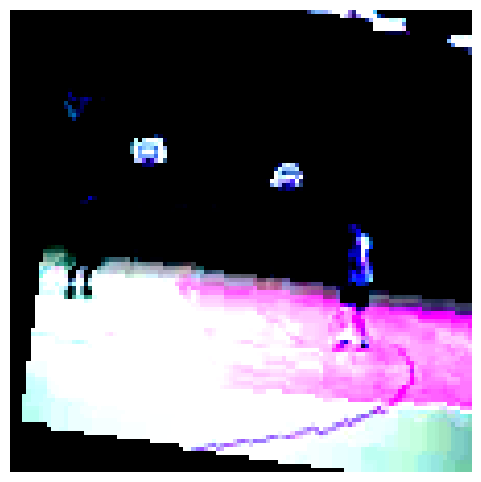

In [8]:
import os
import torch
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from config import Config
from model import CNN_LSTM
from transforms import get_transforms

# Load model function
def load_model():
    model = CNN_LSTM(
        num_classes=Config.num_classes,
        sequence_length=Config.frames_per_clip,
        hidden_dim=Config.hidden_dim,
        lstm_layers=Config.lstm_layers,
        dropout=Config.dropout
    ).to(Config.device)

    checkpoint = torch.load(Config.model_save_path, map_location=Config.device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

# Preprocess video function
def preprocess_video(video_path, transform):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = Image.fromarray(frame)
        frames.append(frame)
    cap.release()

    total_frames = len(frames)
    if total_frames < Config.frames_per_clip:
        frames += [frames[-1]] * (Config.frames_per_clip - total_frames)
    else:
        step = total_frames // Config.frames_per_clip
        frames = frames[::step][:Config.frames_per_clip]

    frames = [transform(frame) for frame in frames]
    frames = torch.stack(frames, dim=0)
    return frames

# Display image
def show_image(image, display_size=(6, 6)):
    plt.figure(figsize=display_size)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Predict a single video
def predict_single_video(video_path, model, transform):
    frames = preprocess_video(video_path, transform)
    frames_for_display = frames[0].permute(1, 2, 0).cpu().numpy()

    frames = frames.unsqueeze(0).to(Config.device)

    with torch.no_grad():
        outputs = model(frames)
        pred = outputs.argmax(dim=1).item()

    predicted_class = Config.class_names[pred]

    print(f"Video: {video_path}")
    print(f"Predicted Class: {predicted_class}")

    print("\n Displaying first frame from the video:")
    show_image(frames_for_display)

    return predicted_class

# Predict all videos in a folder
def predict_videos_in_folder(folder_path):
    model = load_model()
    transform = get_transforms(Config.img_size)

    video_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.avi', '.mp4', '.mov'))]

    print(f"\n Found {len(video_files)} videos in '{folder_path}'\n")

    for video_path in video_files:
        try:
            predict_single_video(video_path, model, transform)
        except Exception as e:
            print(f"Failed to process {video_path}: {e}")
        print("-" * 50)

# Example usage
if __name__ == "__main__":
    video_path = r"data/UCF101/Basketball/v_Basketball_g01_c01.avi"  # single video
    model = load_model()
    transform = get_transforms(Config.img_size)
    predict_single_video(video_path, model, transform)



display video

In [1]:
import torch
import cv2
import os
from PIL import Image
from config import Config
from model import CNN_LSTM
from transforms import get_transforms

def load_model():
    """
    Loads the trained model with the saved state.
    """
    model = CNN_LSTM(
        num_classes=Config.num_classes,
        sequence_length=Config.frames_per_clip,
        hidden_dim=Config.hidden_dim,
        lstm_layers=Config.lstm_layers,
        dropout=Config.dropout
    ).to(Config.device)

    checkpoint = torch.load(Config.model_save_path, map_location=Config.device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

def preprocess_video(video_path, transform):
    """
    Preprocesses a video by extracting frames and applying necessary transformations.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = Image.fromarray(frame)
        frames.append(frame)
    cap.release()

    total_frames = len(frames)
    if total_frames < Config.frames_per_clip:
        frames += [frames[-1]] * (Config.frames_per_clip - total_frames)
    else:
        step = total_frames // Config.frames_per_clip
        frames = frames[::step][:Config.frames_per_clip]

    frames = [transform(frame) for frame in frames]
    frames = torch.stack(frames, dim=0)  # (sequence_length, 3, img_size, img_size)
    return frames

def predict_single_video(video_path, model, transform):
    """
    Predicts the activity for a single video and displays it along with the prediction.
    """
    frames = preprocess_video(video_path, transform)
    frames = frames.unsqueeze(0).to(Config.device)  # add batch dimension

    with torch.no_grad():
        outputs = model(frames)
        pred = outputs.argmax(dim=1)

    predicted_class = Config.class_names[pred.item()]
    print(f"\n{video_path} ➔ Predicted Class: {predicted_class}\n")

    # PLAY the original video with the prediction
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return

    print("Playing the video... Press 'q' to quit.")

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (640, 480))  # Optional: resize for display
        cv2.putText(frame, f'Prediction: {predicted_class}', (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        cv2.imshow('Video Prediction', frame)

        if cv2.waitKey(30) & 0xFF == ord('q'):  # Press 'q' to quit
            break

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    # Replace with your video path
    video_path = r"data/UCF101/Basketball/v_Basketball_g01_c01.avi"  
    model = load_model()
    transform = get_transforms(Config.img_size)
    predict_single_video(video_path, model, transform)


: 